# 主程序 0：训练鉴别器

[WARNING] DEBUG(18514,7f0578def740,python):2022-07-06-10:37:46.629.072 [mindspore/ccsrc/debug/debugger/debugger.cc:95] Debugger] Not enabling debugger. Debugger does not support CPU.


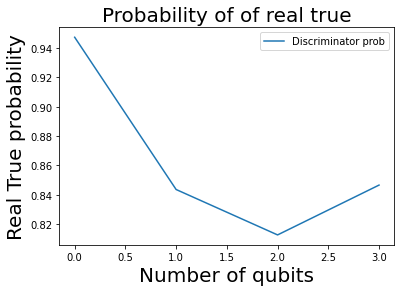

In [1]:
from mindquantum import *
import matplotlib.pyplot as plt
import mindspore as ms
import numpy as np
import time
os.environ['OMP_NUM_THREADS'] = '2'
import mindspore.context as context
from mindspore import Tensor, ops
from mindspore.nn import Adam, LossBase, TrainOneStepCell

ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU") # 训练模式 和 上下文管理器
ms.set_seed(1) # 随机数种子
np.random.seed(1) 

def get_real_paras(qubit_num=2, sample_num=6):
    real_paras = []
    value_len = 2 ** qubit_num 
    for i in range(sample_num):
        data = np.loadtxt('./src/realdata'+str(i)+'.txt')
        sampled_data = data[:,1:4] # omit the timestamp
        sampled_data = sampled_data.reshape(len(sampled_data)*3)
        real_value = sampled_data[0:min(value_len, len(sampled_data))]
        _, parameterResolver = amplitude_encoder(real_value, qubit_num)
        real_paras.append(parameterResolver.para_value)

    return real_paras

def get_fake_paras(qubit_num=2, sample_num=6):
    fake_paras = []
    value_len = 2 ** qubit_num
    values =  np.random.randn(sample_num, value_len)
    for fake_value in values:
        _, parameterResolver = amplitude_encoder(fake_value, qubit_num)
        fake_paras.append(parameterResolver.para_value)
    return fake_paras

def Generator(qubit_num=2):
    circ_, _ =  amplitude_encoder(np.ones(2 ** qubit_num), qubit_num)
    return circ_

def QLayer(qubit_num=2, prefix='0'):
    circ_ = Circuit()
    for qubit in range(qubit_num):
        circ_ += U3(f'{qubit}_0', f'{qubit}_1', f'{qubit}_2', qubit)
    for qubit in range(qubit_num-1):
        circ_ += X.on(qubit+1, qubit)
    circ_ += X.on(0, qubit_num-1)
    circ_ = add_prefix(circ_, prefix)
    return circ_

def Discriminator(qubit_num=2, layer_num=4):
    circ_ = Circuit()
    for _ in range(layer_num): 
        circ_ += QLayer(qubit_num=qubit_num, prefix=f'{_}') 
    return circ_

def build_grad_ops(qubit_num=2, layer_num=4):
    encoder = Generator(qubit_num)
    encoder.no_grad()
    ansatz = Discriminator(qubit_num, layer_num)
    circ = encoder + ansatz
    sim = Simulator('projectq', qubit_num)
    ham = Hamiltonian(QubitOperator('Z0'))
    grad_ops = sim.get_expectation_with_grad(ham, 
                                                                            circ,
                                                                            encoder_params_name=encoder.params_name,
                                                                            ansatz_params_name=ansatz.params_name,
                                                                            parallel_worker = 1) 
    return grad_ops

class MyLoss(LossBase):
    def __init__(self, reduction='mean'):
        super(MyLoss, self).__init__(reduction)
        self.abs = ops.Abs()

    def construct(self, logits, label):
        out =self.abs(logits - label)
        return self.get_loss(out)

class MyWithLossCell(ms.nn.Cell):
   def __init__(self, backbone, loss_fn):
       super(MyWithLossCell, self).__init__(auto_prefix=False)
       self._backbone = backbone
       self._loss_fn = loss_fn

   def construct(self, x, label):
       out = self._backbone(x)
       return self._loss_fn(out, label)

   @property
   def backbone_network(self):
       return self._backbone

sample_num = 6
layer_num = 10
steps = 200
time_list = []
real_probs = []
for qubit_num in [2, 3, 4, 5]:
    real_paras = get_real_paras(qubit_num=qubit_num, sample_num=sample_num)
    fake_paras = get_fake_paras(qubit_num=qubit_num, sample_num=sample_num)

    QuantumNet = MQLayer(build_grad_ops(qubit_num=qubit_num, layer_num=layer_num))
    loss = MyLoss()
    net_with_criterion = MyWithLossCell(QuantumNet, loss)
    opti = Adam(QuantumNet.trainable_params(), learning_rate=0.01)     # 需要优化的是Quantumnet中可训练的参数，学习率设为0.5
    net = TrainOneStepCell(net_with_criterion, opti)

    start_time = time.time()
    for _ in range(steps):
        for i in range(sample_num):
            real_loss = net(Tensor([real_paras[i]]), Tensor([1.]))
            fake_loss = net(Tensor([fake_paras[2]]), Tensor([-1.]))

    real_probs.append((QuantumNet(Tensor([real_paras[i]]))[0,0].asnumpy()+1)/2)
    np.save(f'./src/{qubit_num}_qubit_Discriminator_paras.npy', QuantumNet.weight.asnumpy())
    end_time = time.time()
    time_list.append(end_time - start_time)

plt.figure()
plt.plot(real_probs, label='Discriminator prob', linestyle='-') 
plt.title('Probability of of real true', fontsize=20)
plt.legend() 
plt.xlabel('Number of qubits', fontsize=20)
plt.ylabel('Real True probability', fontsize=20)
plt.savefig('./src/Disciminator_Real_True_probs.png')
plt.show()

np.save(f'./src/Discriminator_prob.npy', real_probs)

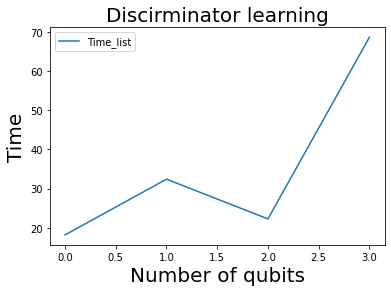

In [2]:
plt.figure()
plt.plot(time_list, label='Time_list', linestyle='-')
plt.title('Discirminator learning', fontsize=20)
plt.legend() 
plt.xlabel('Number of qubits', fontsize=20)
plt.ylabel('Time', fontsize=20)
plt.savefig('./src/Discriminator_training_times.png')
plt.show()
np.save(f'./src/Discriminator_learning.npy', time_list)

# 主程序 1：训练生成器

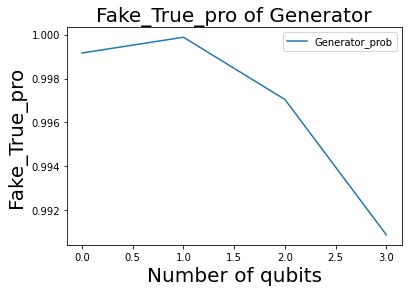

In [3]:
from mindquantum import *
import matplotlib.pyplot as plt
import mindspore as ms
import numpy as np
import time
os.environ['OMP_NUM_THREADS'] = '2'
import mindspore.context as context
from mindspore import Tensor, ops
from mindspore.nn import Adam, LossBase, TrainOneStepCell

ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU") # 训练模式 和 上下文管理器
ms.set_seed(1) # 随机数种子
np.random.seed(1) 

def Generator(qubit_num=2):
    circ_, _ =  amplitude_encoder(np.ones(2 ** qubit_num), qubit_num)
    return circ_

def QLayer(qubit_num=2, prefix='0'):
    circ_ = Circuit()
    for qubit in range(qubit_num):
        circ_ += U3(f'{qubit}_0', f'{qubit}_1', f'{qubit}_2', qubit)
    for qubit in range(qubit_num-1):
        circ_ += X.on(qubit+1, qubit)
    circ_ += X.on(0, qubit_num-1)
    circ_ = add_prefix(circ_, prefix)
    return circ_

def Discriminator(qubit_num=2, layer_num=4):
    circ_ = Circuit()
    for _ in range(layer_num): 
        circ_ += QLayer(qubit_num=qubit_num, prefix=f'{_}') 
    return circ_

def build_grad_ops(qubit_num=2, layer_num=4):
    encoder = Generator(qubit_num)
    ansatz = Discriminator(qubit_num, layer_num)
    ansatz.no_grad()
    circ = encoder + ansatz
    sim = Simulator('projectq', qubit_num)
    ham = Hamiltonian(QubitOperator('Z0'))
    grad_ops = sim.get_expectation_with_grad(ham, 
                                                                            circ,
                                                                            encoder_params_name=ansatz.params_name,
                                                                            ansatz_params_name=encoder.params_name,
                                                                            parallel_worker = 1) 
    return grad_ops

class MyLoss(LossBase):
    def __init__(self, reduction='mean'):
        super(MyLoss, self).__init__(reduction)
        self.abs = ops.Abs()

    def construct(self, logits, label):
        out =self.abs(logits - label)
        return self.get_loss(out)

class MyWithLossCell(ms.nn.Cell):
   def __init__(self, backbone, loss_fn):
       super(MyWithLossCell, self).__init__(auto_prefix=False)
       self._backbone = backbone
       self._loss_fn = loss_fn

   def construct(self, x, label):
       out = self._backbone(x)
       return self._loss_fn(out, label)

   @property
   def backbone_network(self):
       return self._backbone

layer_num = 10
steps = 100
time_list = []
fake_probs = []
for qubit_num in [2, 3, 4, 5]:

    discriminator_paras = np.load(f'./src/{qubit_num}_qubit_Discriminator_paras.npy', allow_pickle=True) 
    QuantumNet = MQLayer(build_grad_ops(qubit_num=qubit_num, layer_num=layer_num))
    loss = MyLoss()
    net_with_criterion = MyWithLossCell(QuantumNet, loss)
    opti = Adam(QuantumNet.trainable_params(), learning_rate=0.05)     # 需要优化的是Quantumnet中可训练的参数，学习率设为0.5
    net = TrainOneStepCell(net_with_criterion, opti)
    start_time = time.time()
    for _ in range(steps):
        fake_loss = net(Tensor([discriminator_paras]), Tensor([1.]))
    fake_probs.append((QuantumNet(Tensor([discriminator_paras]))[0,0].asnumpy()+1)/2)
    end_time = time.time()
    time_list.append(end_time - start_time)

plt.figure()
plt.plot(fake_probs, label='Generator_prob', linestyle='-')
plt.title('Fake_True_pro of Generator', fontsize=20)
plt.legend() 
plt.xlabel('Number of qubits', fontsize=20)
plt.ylabel('Fake_True_pro', fontsize=20)
plt.savefig('./src/Generator_Fake_True_probs.png')
plt.show()

np.save(f'./src/Generator_prob.npy', real_probs)

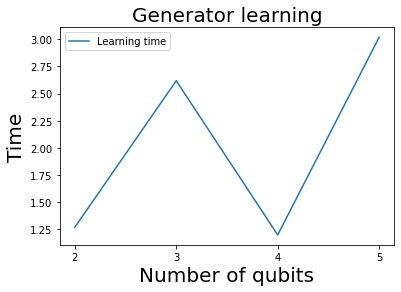

In [4]:
plt.figure()
plt.plot(time_list, label='Learning time', linestyle='-')
plt.title('Generator learning', fontsize=20)
plt.legend() 
plt.xlabel('Number of qubits', fontsize=20)
plt.xticks(ticks=[0, 1, 2, 3],labels=[2, 3, 4, 5])
plt.ylabel('Time', fontsize=20)
plt.savefig('./src/Generatorr_training_times.png')
plt.show()
np.save(f'./src/Generator_learning.npy', time_list)